# 溫度分布-小時溫度觀測分析格點資料分析 313652018

## 0.資料可視化
先把xml資料讀出，畫熱圖(120*67)

In [2]:
import re, math, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

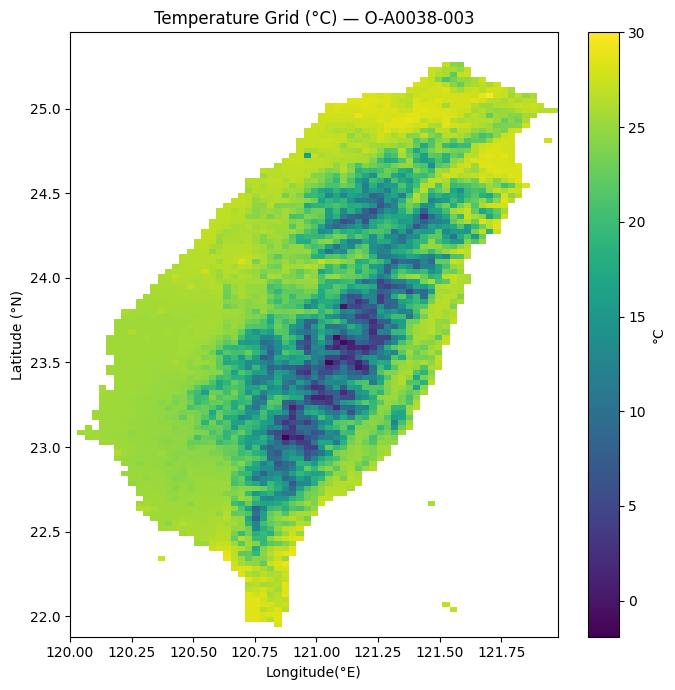

In [5]:
xml_path="O-A0038-003.xml"
save_pig="O-A0038-003_heatMap.png"

text=Path(xml_path).read_text(encoding='utf-8', errors='ignore')
m=re.search(r"<Content>(.*?)</Content>", text, flags=re.DOTALL)
content = m.group(1)

tokens = re.findall(r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?", content)
arr = np.array([float(t) for t in tokens], dtype = float)

H, W = 120, 67 #緯度120 經度67
#assert arr.size == H*W  f"資料長度不符，got={arr.size}, expected={H*W}"
grid = arr.reshape(H,W)
grid[grid == -999.0] = np.nan

lon0, lat0,d = 120.00, 21.88, 0.03
lons = lon0 + d*np.arange(W) #67
lats = lat0 + d*np.arange(H) #120

plt.figure(figsize=(7,7))
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
im = plt.imshow(grid, origin = "lower", extent=extent, aspect="auto")
plt.xlabel("Longitude(°E)")
plt.ylabel("Latitude (°N)")
plt.title("Temperature Grid (°C) — O-A0038-003")
plt.colorbar(im, label="°C")
plt.tight_layout()
plt.savefig(save_pig, dpi=200)
plt.show()




## Problem 1.
將原始資料轉換為兩個監督式學習資料集：  
  
a. 分類 (Classification) 資料集
* 格式：(精度, 緯度, label)
* 規則：
    * 若溫度觀測值為 無效值 -999，則 label = 0。
    * 若溫度觀測值為 有效值，則 label = 1。
b. 回歸 (Regression) 資料集  
* 格式：(精度, 緯度, Value)
* 規則：
  * 僅保留有效的溫度觀測值（剔除所有 -999.）。
  * value 為對應的攝氏溫度。

In [8]:
OUT_CLS  = "classification_dataset.csv"
OUT_REG  = "regression_dataset.csv"

W_LON = 67  #緯度
H_LAT = 120 #經度
lon0, lat0, d=120.00, 21.88, 0.03 #起點與解析度

vals = np.array([float(t) for t in tokens], dtype=float)
grid = vals.reshape(H_LAT, W_LON)
lons=lon0+d*np.arange(W_LON)
lats=lat0+d*np.arange(H_LAT)
LAT, LON = np.meshgrid(lats, lons, indexing="ij") #shape=(120,67)

#----------
#### Classification dataset

label = np.where(grid == -999.0, 0, 1).astype(int)
df_cls = pd.DataFrame({
    "lon": LON.ravel(),
    "lat": LAT.ravel(),
    "label": label.ravel()
})
df_cls.to_csv(OUT_CLS, index=False)
print(f"Saved: {OUT_CLS} | rows={len(df_cls)}, positives={df_cls['label'].sum()}, negatives={(df_cls['label']==0).sum()}")

#----------
#### Classification dataset

mask = grid != -999.0
df_reg = pd.DataFrame({
    "lon": LON[mask],
    "lat": LAT[mask],
    "value": grid[mask]
})
df_reg.to_csv(OUT_REG, index=False)

#-----------
print(f"Saved: {OUT_REG} | rows={len(df_reg)}, min={df_reg['value'].min():.2f}, max={df_reg['value'].max():.2f}, mean={df_reg['value'].mean():.2f}")



Saved: classification_dataset.csv | rows=8040, positives=3495, negatives=4545
Saved: regression_dataset.csv | rows=3495, min=-1.90, max=30.00, mean=21.59


## Problem 2. 模型訓練
使用 Problem 1. 中整理出的兩個資料集，分別訓練一個簡單的機器學習模型：

* 分類模型 (classification model)：
    * 以 (精度, 緯度) 預測格點資料是否為有效值 (0 或 1)。

* 回歸模型 (regression model)：
    * 以 (精度, 緯度) 預測對應的溫度觀測值。

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error


### 2.(a) 分類模型

In [10]:
df_cls = pd.read_csv("classification_dataset.csv")
X_cls = df_cls[["lon", "lat"]]
y_cls = df_cls["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state = 42, stratify = y_cls
)

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Claddification Model => Logistic Regression ===")
print(classification_report(y_test, y_pred, digits=3))
print("混淆矩陣：\n", confusion_matrix(y_test, y_pred))


=== Claddification Model => Logistic Regression ===
              precision    recall  f1-score   support

           0      0.565     1.000     0.722       909
           1      0.000     0.000     0.000       699

    accuracy                          0.565      1608
   macro avg      0.283     0.500     0.361      1608
weighted avg      0.320     0.565     0.408      1608

混淆矩陣：
 [[909   0]
 [699   0]]


c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 2.(b) 回歸模型

In [13]:
df_reg = pd.read_csv("regression_dataset.csv")
X_reg = df_reg[["lon", "lat"]]
y_reg = df_reg["value"]
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state = 42
)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("\n=== Regression Model => Linear Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)                       
print("RMSE:", rmse)



=== Regression Model => Linear Regression ===
MAE: 4.398637237716326
RMSE: 5.669482982484731
